# (Title to be decided)

*This is the file for the code of our group assignment. Under development.*

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## 1. Read Data from External File

Read data in external files. For convenience, the original `.pcapng` file has been converted into `.json` and `.csv` with Wireshark.

In [2]:
# Read the JSON including all details of packets
#   errors="surrogateescape" to pass the encoding errors raised by contents in HTTP packets
with open("./data/traffic.json", "r", encoding="utf-8", errors="surrogateescape") as f:
    dataset_json=json.load(f)
    print(f"{len(dataset_json)} packets read")

# print one for checking
dataset_json[0]

In [3]:
# # TODO: UNUSED - REMOVE LATER
# # Read the CSV
# # TODO: Info in CSV should be covered by the one in JSON.
# #       Remove it in the future if not used
# dataset_csv=pd.read_csv("./data/traffic.csv")

# dataset_csv

## 2. Data Preprocessing

### 2.1 Extract dataset labels

In [4]:
# Extract labels(y) from JSON
dataset_y = np.array(list(map(
    lambda packet_json: (packet_json["_source"]["layers"]["pkt_comment"]["frame.comment"]).split(",")[1], 
    dataset_json
)))

print(f"Labels include {np.unique(dataset_y)}")
print(dataset_y.shape)

### 2.2 Extract features

In [5]:
# Extract source IP, source IP host, destination IP and destination IP host from dataset
dataset_X_ip_src = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.src"], 
    dataset_json
)))
dataset_X_ip_src_host = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.src_host"], 
    dataset_json
)))
dataset_X_ip_dst = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.dst"], 
    dataset_json
)))
dataset_X_ip_dst_host = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.dst_host"], 
    dataset_json
)))

# print first ones for checking
print(dataset_X_ip_src[0])
print(dataset_X_ip_src_host[0])
print(dataset_X_ip_dst[0])
print(dataset_X_ip_dst_host[0])


### 2.3 Check data sanity and deal with missing fields

In [6]:
# Data sanity check
pattern_not_ipv4 = re.compile(r"(?!((\b25[0-5]|\b2[0-4][0-9]|\b[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}))")
pattern_not_ipv4_nor_domain = re.compile(r"(?!((\b25[0-5]|\b2[0-4][0-9]|\b[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3})|[-_0-9a-zA-Z]+\.[-_0-9a-zA-Z]+)")

print("Source/dest IP not an IPv4 address:")
print(list(filter(pattern_not_ipv4.match, dataset_X_ip_src)))
print(list(filter(pattern_not_ipv4.match, dataset_X_ip_dst)))
print("Source/dest host not an IPv4 nor a domain:")
print(list(filter(pattern_not_ipv4_nor_domain.match, dataset_X_ip_src_host)))
print(list(filter(pattern_not_ipv4_nor_domain.match, dataset_X_ip_dst_host)))

print()

# Fill the missing `dst.host`
#
# Find "no-data" rows
missing_dst_host_indexes = np.where(dataset_X_ip_dst_host=='no-data')[0]
print(f"Indexes of rows with missing 'dst.host': {missing_dst_host_indexes}")

# Fill the field with the IP address in `dst`, following the way of other rows
for i in missing_dst_host_indexes:
    dataset_X_ip_dst_host[i] = dataset_X_ip_dst[i]

print("Missing 'dst.host' filled")

### 2.4 Bi-gram for similarity between IPs and domains

In [7]:
# bi-gram for similar IP and hostnames
bigram_vec = CountVectorizer(ngram_range=(2, 2), token_pattern=r"(?u)[^.]+")
dataset_X_ip_src_bg = bigram_vec.fit_transform(dataset_X_ip_src).toarray()
dataset_X_ip_src_host_bg = bigram_vec.fit_transform(dataset_X_ip_src_host).toarray()
dataset_X_ip_dst_bg = bigram_vec.fit_transform(dataset_X_ip_dst).toarray()
dataset_X_ip_dst_host_bg = bigram_vec.fit_transform(dataset_X_ip_dst_host).toarray()

print(dataset_X_ip_src_bg.shape)
print(dataset_X_ip_src_host_bg.shape)
print(dataset_X_ip_dst_bg.shape)
print(dataset_X_ip_dst_host_bg.shape)

dataset_X = np.concatenate((
    dataset_X_ip_src_bg, 
    dataset_X_ip_src_host_bg,
    dataset_X_ip_dst_bg, 
    dataset_X_ip_dst_host_bg), axis=1)

print("")
print(dataset_X.shape)


### 2.5 Normalization

In [8]:
# Normalization
dataset_X = MinMaxScaler().fit_transform(dataset_X)
print(dataset_X.shape)

### 2.6 Principal Component Analysis (PCA)

In [9]:
# # PCA - check the 95% with figure
# pca = PCA()
# pca.fit(dataset_X)
# pca_cumsum = np.cumsum(pca.explained_variance_ratio_)

# plt.figure()
# plt.axis([0, dataset_X.shape[1], 0, 1]) 
# plt.plot(pca_cumsum)
# plt.axhline(y=0.95,color='red')
# plt.xlabel("dimensions")
# plt.ylabel("explained variance")
# plt.grid(True)
# plt.show()

In [ ]:
# Apply PCA for compression
pca = PCA(n_components=0.95)
dataset_X = pca.fit_transform(dataset_X)

print(dataset_X.shape)

### 2.7 Label encoding the string label for y

In [21]:
from sklearn.preprocessing import LabelEncoder
dataset_y = LabelEncoder().fit_transform(dataset_y).reshape(-1,1)

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### 2.8 Dataset split

In [22]:
# Split the dataset into training set and testing set
train_X, test_X, train_y, test_y = train_test_split(dataset_X, dataset_y, random_state=12345)

print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)
train_X

(7968, 650)
(7968, 1)
(2657, 650)
(2657, 1)


array([[-1.08502832e+00,  1.35391675e+00, -8.98510724e-02, ...,
         1.61431542e-05, -3.24287461e-03, -4.02308876e-05],
       [-1.37256606e+00, -1.30645738e+00, -2.43504060e-03, ...,
         1.47518527e-05,  6.61440472e-03, -2.26175618e-04],
       [-1.44957648e+00, -1.28237230e+00, -1.15245375e-02, ...,
         9.79593372e-06,  7.32780186e-04, -1.83503984e-05],
       ...,
       [-1.35841130e+00, -1.32739694e+00, -2.06831953e-04, ...,
         3.10242879e-06, -2.13589786e-02, -3.19577991e-05],
       [ 1.52944088e+00, -2.97314827e-02,  1.42330582e+00, ...,
         4.08650518e-03,  6.30412056e-06,  2.91432256e-03],
       [ 1.81760780e+00, -1.45667155e-01, -1.16834515e+00, ...,
         3.43173962e-03,  3.24887331e-06,  1.48616571e-03]])

### 2.X kNN classification as an example for using the processed dataset

(And for checking the preprocess performance at the early stage)

TODO: REMOVE BEFORE FINAL SUBMIT

In [23]:
# kNN classification test
#
# TODO: A brief test for evaluating performance during writing preprocessin code, 
#       gonna be removed later
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_X, train_y)
print(f"Accuracy on test set: {knn.score(test_X, test_y):.4f}")

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy on test set: 0.8457


## 3. Model Training

### 3.1 Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_X, train_y)

# evaluating the lr performance using auc,f1, precision,recall, and accuracy
from sklearn.metrics import classification_report, \
    roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
y_pred = lr.predict_proba(test_X)[:, 1]
y_pred = y_pred.reshape(-1,1)

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### evaluating the performance for lr

In [26]:
f1 = f1_score(test_y, y_pred.round(0),average='macro')
recall = recall_score(test_y, y_pred.round(0),average='macro')
precision = precision_score(test_y, y_pred.round(0),average='macro')
acc = accuracy_score(test_y, y_pred.round(0))
print(classification_report(test_y, y_pred.round(0)))
print(f'accuracy: {acc}, f1: {f1}, recall: {recall}, precision: {precision}')

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       741
           1       0.96      0.82      0.89      1031
           2       0.00      0.00      0.00       885

    accuracy                           0.60      2657
   macro avg       0.46      0.61      0.49      2657
weighted avg       0.49      0.60      0.51      2657

accuracy: 0.5972901768912308, f1: 0.49148191025691657, recall: 0.6067276550200641, precision: 0.4599309898549371


/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/py38/lib/pytho

### 3.2 Support Vector Machine (SVM)

TODO

### 3.3 (?) neural network

Maybe?

In [27]:
from tensorflow import keras

keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[train_X.shape[1]]),
    keras.layers.Dense(300, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(300, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(3, activation="softmax")
])

print(model.summary())
print(model.output_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               195300    
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 dense_2 (Dense)             (None, 3)                 903       
                                                                 
Total params: 286,503
Trainable params: 286,503
Non-trainable params: 0
_________________________________________________________________
None
(None, 3)


In [28]:
opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [29]:
temp_train_y = pd.DataFrame(train_y, columns=['country'])
temp_train_y = pd.factorize(temp_train_y['country'])[0]
train_X_nn, validate_X, train_y_nn, validate_y = train_test_split(train_X, temp_train_y)

train_y_nn = keras.utils.to_categorical(train_y_nn, 3).astype('int32')
validate_y = keras.utils.to_categorical(validate_y, 3).astype('int32')

print(train_X_nn.shape)
print(validate_X.shape)
print(train_y_nn.shape)
print(validate_y.shape)

(5976, 650)
(1992, 650)
(5976, 3)
(1992, 3)


In [30]:
history = model.fit(train_X_nn, train_y_nn, epochs=20,
                    validation_data=(validate_X, validate_y))

Epoch 1/20
187/187 [==============================] - 0s 2ms/step - loss: 0.4123 - accuracy: 0.8258 - val_loss: 0.2599 - val_accuracy: 0.8825
Epoch 2/20
187/187 [==============================] - 0s 1ms/step - loss: 0.2380 - accuracy: 0.8839 - val_loss: 0.2434 - val_accuracy: 0.8906
Epoch 3/20
187/187 [==============================] - 0s 1ms/step - loss: 0.2265 - accuracy: 0.8884 - val_loss: 0.2469 - val_accuracy: 0.8820
Epoch 4/20
187/187 [==============================] - 0s 1ms/step - loss: 0.2143 - accuracy: 0.8906 - val_loss: 0.2403 - val_accuracy: 0.8860
Epoch 5/20
187/187 [==============================] - 0s 1ms/step - loss: 0.2093 - accuracy: 0.8912 - val_loss: 0.2471 - val_accuracy: 0.8800
Epoch 6/20
187/187 [==============================] - 0s 1ms/step - loss: 0.2066 - accuracy: 0.8929 - val_loss: 0.2410 - val_accuracy: 0.8830
Epoch 7/20
187/187 [==============================] - 0s 1ms/step - loss: 0.2021 - accuracy: 0.8934 - val_loss: 0.2435 - val_accuracy: 0.8825
Epoch 

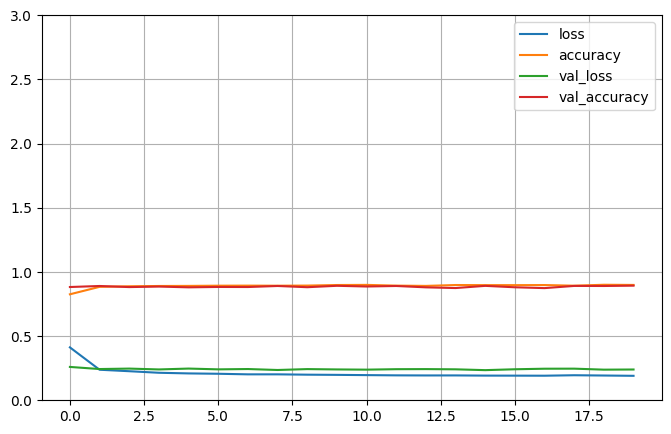

In [31]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

## 4. Model Testing and Comparison

TODO